In [24]:
import torch
torch.manual_seed(0)
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [25]:
noise_dim = 64 # generator model

# optimizers parameters
learning_rate = 0.0002
beta_1 = 0.5
beta_2 = 0.99

# training variables
epochs = 20

In [26]:
from torchvision import datasets, transforms

In [27]:
train_augs = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

In [28]:
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=train_augs)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=train_augs)

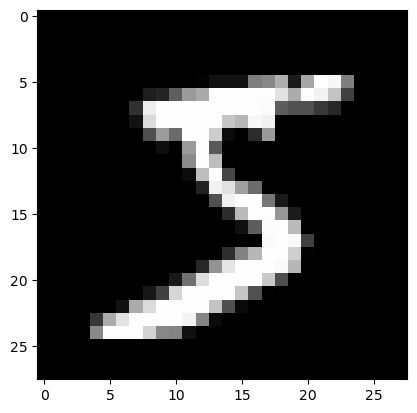

In [29]:
image, label = mnist_train[0]
plt.imshow(image.squeeze(), cmap='gray')

In [30]:
from torch.utils.data import DataLoader
from torchvision.utils import make_grid

In [31]:
batch_size = 128
trainloader = DataLoader(mnist_train, batch_size, shuffle = True)

In [32]:
dataiter = iter(trainloader)

images, _ =  next(dataiter)

print(images.shape)

torch.Size([128, 1, 28, 28])


In [33]:
def show_tensor_images(tensor_img, num_images = 16, size=(1, 28, 28)):
    unflat_img = tensor_img.detach().cpu()
    img_grid = make_grid(unflat_img[:num_images], nrow=4)
    plt.imshow(img_grid.permute(1, 2, 0).squeeze())
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


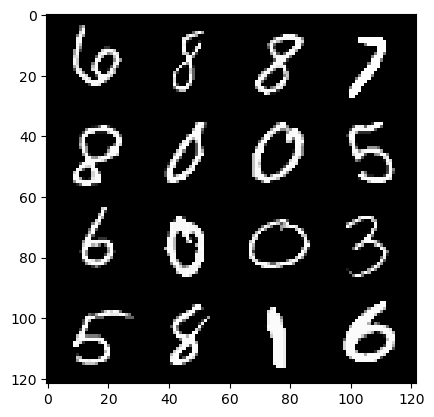

In [34]:
show_tensor_images(images)

In [35]:
from torch import nn
from torchinfo import summary

In [36]:
def get_disc_block(in_channels, out_channels, kernel_size, stride):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.LeakyReLU(0.2)
  )

In [37]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()

    self.block_1 = get_disc_block(1, 16, (3,3), 2)
    self.block_2 = get_disc_block(16, 32, (5,5), 2)
    self.block_3 = get_disc_block(32, 64, (5,5), 2)

    self.flatten = nn.Flatten()
    self.linear = nn.Linear(in_features = 64, out_features = 1)

  def forward(self, images):
    x1 = self.block_1(images)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.flatten(x3)
    x5 = self.linear(x4)

    return x5

In [38]:
D = Discriminator()

summary(D)

Layer (type:depth-idx)                   Param #
Discriminator                            --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       160
│    └─BatchNorm2d: 2-2                  32
│    └─LeakyReLU: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       12,832
│    └─BatchNorm2d: 2-5                  64
│    └─LeakyReLU: 2-6                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-7                       51,264
│    └─BatchNorm2d: 2-8                  128
│    └─LeakyReLU: 2-9                    --
├─Flatten: 1-4                           --
├─Linear: 1-5                            65
Total params: 64,545
Trainable params: 64,545
Non-trainable params: 0

In [39]:
def get_gen_block(in_channels, out_channels, kernel_size, stride, final_block = False):
  if final_block == True:
    return nn.Sequential(
        nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
        nn.Tanh()
    )

  return nn.Sequential(
      nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
  )

In [40]:
class Generator(nn.Module):
  def __init__(self, noise_dim):
    super(Generator, self).__init__()

    self.noise_dim = noise_dim
    self.block_1 = get_gen_block(noise_dim, 256, (3,3), 2)
    self.block_2 = get_gen_block(256, 128, (4,4), 1)
    self.block_3 = get_gen_block(128, 64, (3,3), 2)


    self.block_4 = get_gen_block(64, 1, (4,4), 2, final_block = True)

  def forward(self, r_noise_vec):
    # (bs, noise_dim) -> (bs, noise_dim, 1, 1)
    x = r_noise_vec.view(-1, self.noise_dim, 1, 1)
    x1 = self.block_1(x)
    x2 = self.block_2(x1)
    x3 = self.block_3(x2)
    x4 = self.block_4(x3)

    return x4

In [41]:
G = Generator(noise_dim)
summary(G)

Layer (type:depth-idx)                   Param #
Generator                                --
├─Sequential: 1-1                        --
│    └─ConvTranspose2d: 2-1              147,712
│    └─BatchNorm2d: 2-2                  512
│    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
│    └─ConvTranspose2d: 2-4              524,416
│    └─BatchNorm2d: 2-5                  256
│    └─ReLU: 2-6                         --
├─Sequential: 1-3                        --
│    └─ConvTranspose2d: 2-7              73,792
│    └─BatchNorm2d: 2-8                  128
│    └─ReLU: 2-9                         --
├─Sequential: 1-4                        --
│    └─ConvTranspose2d: 2-10             1,025
│    └─Tanh: 2-11                        --
Total params: 747,841
Trainable params: 747,841
Non-trainable params: 0

In [42]:
# Replace Random initialized weights to Normal weights

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        nn.init.normal_(m.weight, 0.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [43]:
D = D.apply(weights_init)
G = G.apply(weights_init)

In [44]:
def real_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.ones_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

def fake_loss(disc_pred):
  criterion = nn.BCEWithLogitsLoss()
  ground_truth = torch.zeros_like(disc_pred)
  loss = criterion(disc_pred, ground_truth)
  return loss

In [45]:
D_opt = torch.optim.Adam(D.parameters(), lr = learning_rate, betas = (beta_1, beta_2))
G_opt = torch.optim.Adam(G.parameters(), lr = learning_rate, betas = (beta_1, beta_2))

In [46]:
for i in range(epochs):
  total_d_loss = 0.0
  total_g_loss = 0.0

  for real_img, _ in tqdm(trainloader):
    noise = torch.randn(batch_size, noise_dim)

    #find loss & update weights for D

    D_opt.zero_grad()

    fake_img = G(noise)
    D_pred = D(fake_img)
    D_fake_loss = fake_loss(D_pred)

    D_pred = D(real_img)
    D_real_loss = real_loss(D_pred)

    D_loss = (D_fake_loss + D_real_loss)/2

    total_d_loss += D_loss.item()

    D_loss.backward()
    D_opt.step()

    #find loss & update weights for G

    G_opt.zero_grad()

    noise = torch.randn(batch_size, noise_dim)

    fake_img = G(noise)
    D_pred = D(fake_img)
    G_loss = real_loss(D_pred)

    total_g_loss += G_loss.item()

    G_loss.backward()
    G_opt.step()

  avg_d_loss = total_d_loss / len(trainloader)
  avg_g_loss = total_g_loss / len(trainloader)

  print("Epoch: {} | D loss: {} | G loss: {} |".format(i+1, avg_d_loss, avg_g_loss))
  show_tensor_images(fake_img)

  0%|          | 0/469 [00:00<?, ?it/s]

KeyboardInterrupt: 